In [66]:
from __future__ import absolute_import, division, print_function


import multiprocessing
import os , json , requests
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import matplotlib.pyplot as plt

In [3]:
"""**Download NLTK tokenizer models (only the first time)**"""

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/aditya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
"""## Prepare Corpus

**Load books from url**
"""
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return list(map(lambda x:x.lower(),words))
  
filepath = 'http://www.gutenberg.org/files/33224/33224-0.txt'

corpus_raw = requests.get(filepath).text

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)


#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
        
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 425,633 tokens


In [6]:
"""## Train Word2Vec"""
    


num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.

#more workers, faster we train
num_workers = multiprocessing.cpu_count()

context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1


client2vec = w2v.Word2Vec(
            sg=1,
            seed=seed,
            workers=num_workers,
            size=num_features,
            min_count=min_word_count,
            window=context_size,
            sample=downsampling
        )
        
client2vec.build_vocab(sentences)

client2vec.corpus_count

18225

In [7]:
"""**Start training, this might take a minute or two...**"""

client2vec.train(sentences ,total_examples=client2vec.corpus_count , epochs=10)

"""**Save to file, can be useful later**"""

if not os.path.exists(os.path.join("trained",'sample')):
    os.makedirs(os.path.join("trained",'sample'))

client2vec.save(os.path.join("trained",'sample', ".w2v"))

In [8]:
client2vec.most_similar("earth")

/home/aditya/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('crust', 0.7508139610290527),
 ('globe', 0.6789374351501465),
 ('planet', 0.6220108270645142),
 ('inequalities', 0.608557939529419),
 ('orbit', 0.5882158279418945),
 ('remodelled', 0.5871889591217041),
 ('laboring', 0.5857095122337341),
 ('superficial', 0.5831165909767151),
 ('moon', 0.5768727660179138),
 ('primitive', 0.5727148056030273)]

In [9]:
client2vec.most_similar_cosmul(positive=['moon','earth'], negative=['orbit'])

/home/aditya/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  if __name__ == '__main__':


[('crust', 0.8397936820983887),
 ('remodelled', 0.8170954585075378),
 ('heaven', 0.8108218312263489),
 ('autobiography', 0.8043327331542969),
 ('thy', 0.8026232719421387),
 ('sound', 0.8000038862228394),
 ('lio', 0.798740029335022),
 ('letters', 0.7977706789970398),
 ('god', 0.7965680360794067),
 ('sun', 0.7949051856994629)]

In [10]:
#Making the Cluster plot
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

all_word_vectors_matrix = client2vec.wv.vectors




all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[client2vec.wv.vocab[word].index])
            for word in client2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [11]:
points.head(10)

,word,x,y
0,journal,-8.072455,-5.438902
1,compensating,-1.702160,0.039653
2,gun,-1.490910,-2.361844
3,previously,-0.356495,-0.263059
4,precise,-3.159712,-2.466788
5,limestone,5.835257,-5.988907
6,dies,-0.130096,-3.982930
7,public,-0.104572,-9.072804
8,revived,-0.780696,-4.059630
9,reculver,6.170154,-3.381967


In [106]:
sns.set_context("poster")
    
ax = points.plot.scatter("x", "y", s=15, figsize=(20, 12))


fig = ax.get_figure()
fig.savefig(os.path.join("trained",'sample'+".png"))

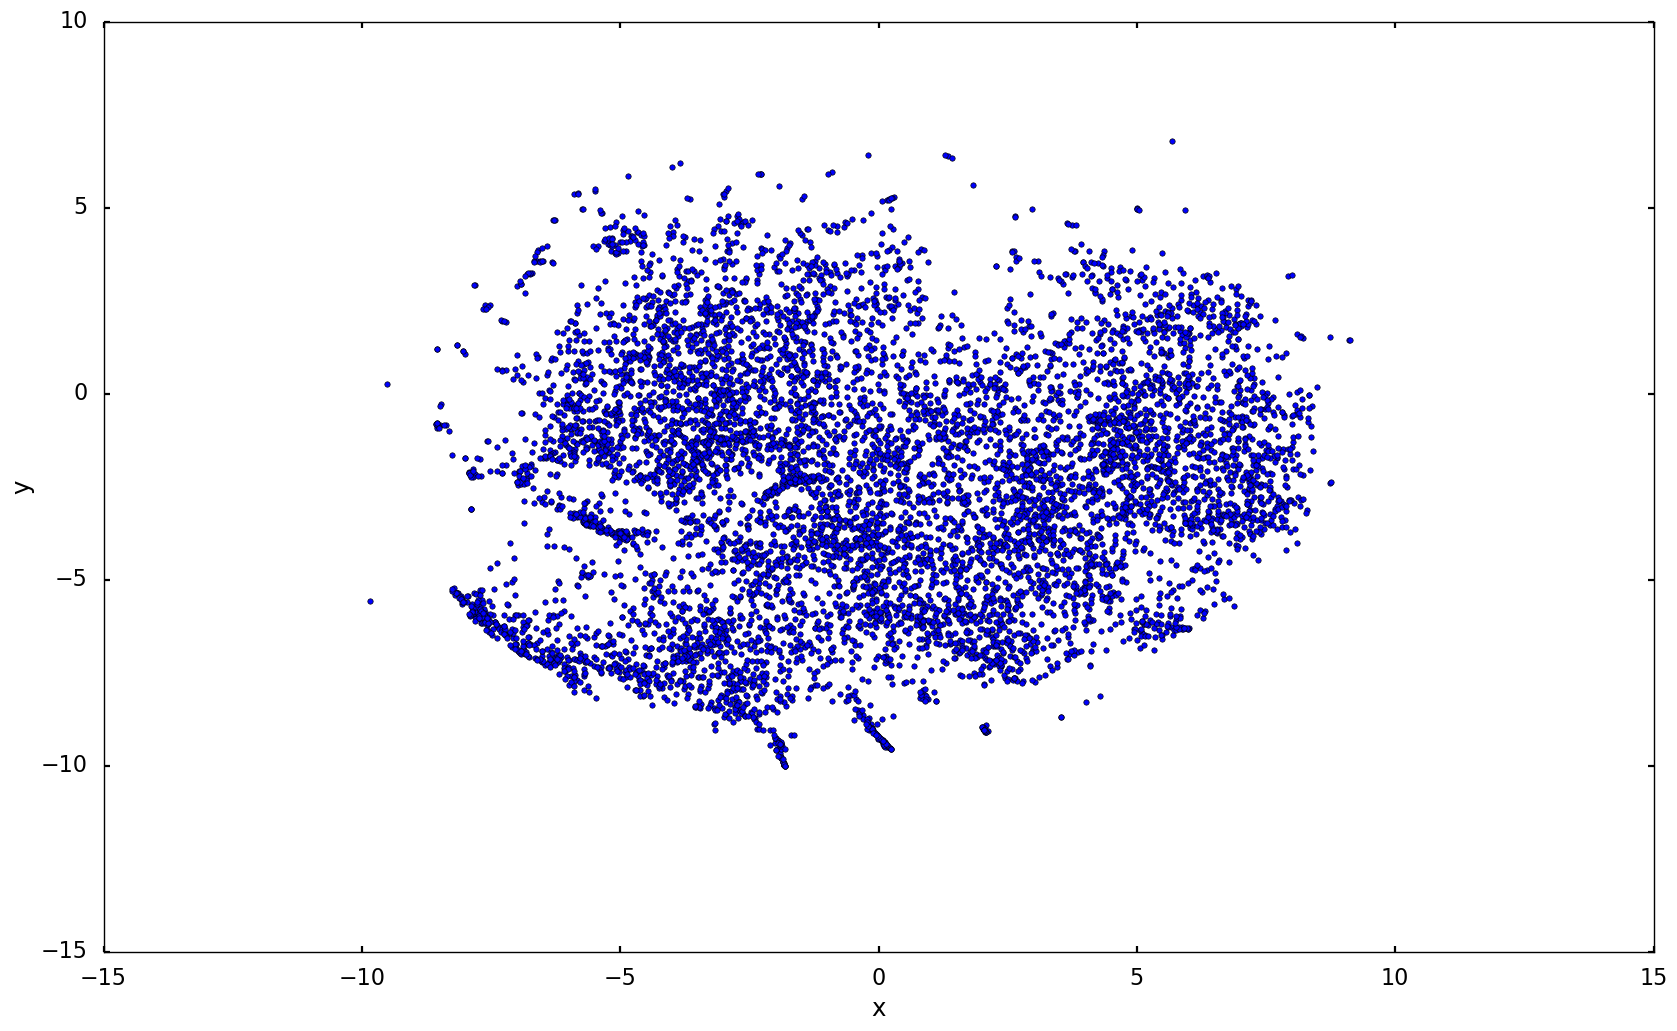

In [107]:
fig

In [110]:
from IPython.display import Image

In [111]:

def plot_region(x_bounds, y_bounds):
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]
        
        ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x+0.005, point.y+0.005 , point.word, fontsize=11)
            
        fig = ax.get_figure()
        fig.savefig(os.path.join("trained",'samplee'+".png"))

        

In [112]:
plot_region(x_bounds=(4, 6), y_bounds=(0, 4))

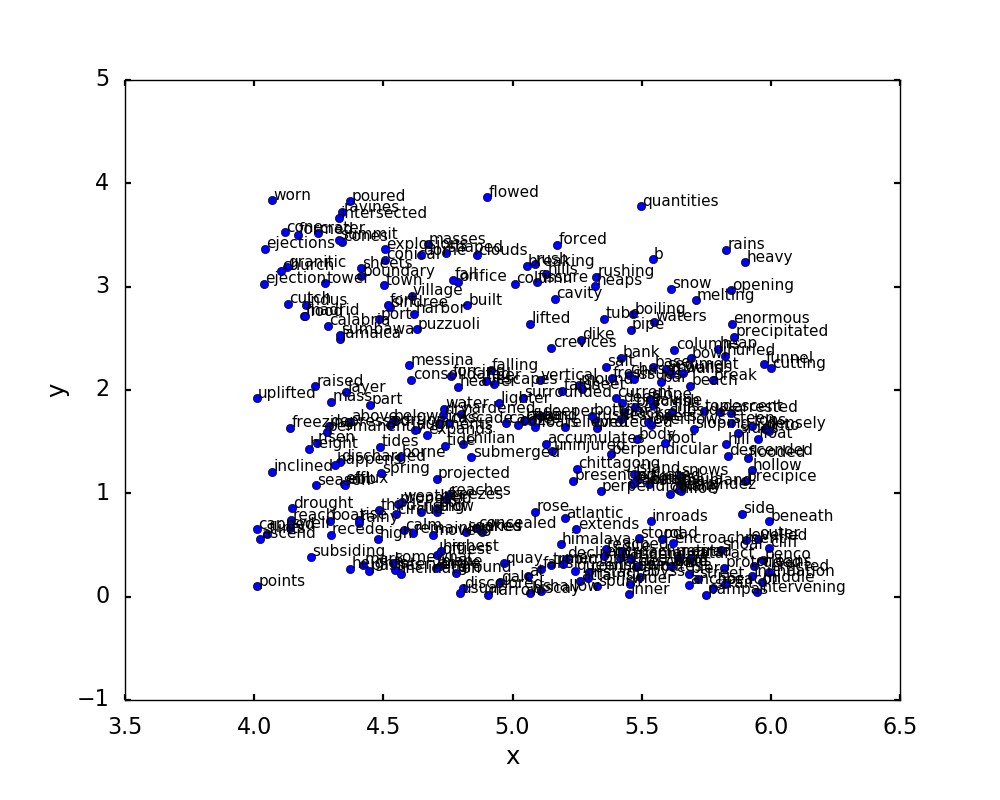

In [113]:
Image("trained/samplee.png")

In [114]:
client2vec.predict_output_word(['earth','orbit'])

[('s', 0.008251761),
 ('crust', 0.0045735207),
 ('inequalities', 0.0025193603),
 ('rotation', 0.0022811824),
 ('surface', 0.0022060676),
 ('sun', 0.0016758397),
 ('axis', 0.001478224),
 ('orbit', 0.0014730901),
 ('fluidity', 0.0014150671),
 ('reduce', 0.0014123103)]

In [115]:
vocab_list = points.word.values.tolist()
embeddings = all_word_vectors_matrix


embedding_var = tf.Variable(all_word_vectors_matrix, dtype='float32', name='embedding')
projector_config = projector.ProjectorConfig()


embedding = projector_config.embeddings.add()
embedding.tensor_name = embedding_var.name

LOG_DIR='./'
metadata_file = os.path.join("sample.tsv")



with open(os.path.join(LOG_DIR, metadata_file), 'wt') as metadata:
    metadata.writelines("%s\n" % w.encode('utf-8') for w in vocab_list)

embedding.metadata_path =  os.path.join(os.getcwd(), metadata_file)

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(LOG_DIR)

# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, projector_config)

saver = tf.train.Saver([embedding_var])

with tf.Session() as sess:
    # Initialize the model
    sess.run(tf.global_variables_initializer())

    saver.save(sess, os.path.join(LOG_DIR, metadata_file+'.ckpt'))

In [117]:
LOG_DIR = './'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')
! cat url.txt

your url is: https://pretty-pug-27.localtunnel.me
